<a href="https://colab.research.google.com/github/NadiaCarvalho/SMC-BachLatentNavigation/blob/main/BachLatentNavigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
# @title Dependencies loading

!pip install pretty_midi -q
!pip install umap-learn -q
!apt install libgraphviz-dev -q
!pip install pygraphviz -q
!pip install networkx==3.2.1 -q
!pip install pypianoroll -q
!pip install plotly -q
!pip install syvmo -q

!pip install torch>=2.0.0 -q
!pip install tensorboardX -q
!pip install lightning -q

import torch
print('torch version:', torch.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 781.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archiv

In [ ]:
# @title Musescore Settings

!apt-get update -q && apt-get install musescore lilypond -q
%env QT_QPA_PLATFORM=offscreen

import music21

env = music21.environment.Environment()
env['lilypondPath'] = '/usr/local/bin/lilypond'

env['pdfPath'] = '/usr/bin/musescore'
env['graphicsPath'] = '/usr/bin/musescore'

env['musicxmlPath'] = '/usr/bin/musescore'
env['musescoreDirectPNGPath'] = '/usr/bin/musescore'
env['autoDownload'] = 'allow'

env['warnings'] = 0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,647 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,234 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,622 kB]
Hit:13 https://ppa.launchpadcontent.

In [ ]:
# @title MODEL definition
### Dependencies
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 25 13:41:24 2020

@author: prang
"""
import random
from typing import Any, Dict, Optional

import lightning as L
import torch  # type: ignore
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torch import nn  # type: ignore
### Encoder
class Encoder_RNN(nn.Module):

    def __init__(self, input_dim, hidden_size, latent_size, num_layers,
                 dropout=0.5, packed_seq=False, device='cpu'):
        """ This initializes the encoder """
        super(Encoder_RNN, self).__init__()

        # Parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.packed_seq = packed_seq
        self.batch_first = True
        self.device = device

        # Layers
        self.RNN = nn.LSTM(input_dim, hidden_size, batch_first=self.batch_first,
                           num_layers=num_layers, bidirectional=True,
                           dropout=dropout)

    def forward(self, x, h0, c0, batch_size):

        # Pack sequence if needed
        if self.packed_seq:
            x = torch.nn.utils.rnn.pack_padded_sequence(x[0], x[1],
                                                        batch_first=self.batch_first,
                                                        enforce_sorted=False)
        # Forward pass
        _, (h, _) = self.RNN(x, (h0, c0))

        # Be sure to not have NaN values
        assert ((h == h).all()), 'NaN value in the output of the RNN, try to \
                                lower your learning rate'
        h = h.view(self.num_layers, 2, batch_size, -1)
        h = h[-1]
        h = torch.cat([h[0], h[1]], dim=1)

        return h

    def init_hidden(self, batch_size=1):
        # Bidirectional -> num_layers * 2
        return (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size,
                            dtype=torch.float, device=self.device),) * 2
### Decoder
class Decoder_RNN_hierarchical(nn.Module):

    def __init__(self, input_size, latent_size, cond_hidden_size, cond_outdim,
                 dec_hidden_size, num_layers, num_subsequences, seq_length,
                 teacher_forcing_ratio=0, dropout=0.5):
        """ This initializes the decoder """
        super(Decoder_RNN_hierarchical, self).__init__()

        # Parameters
        self.num_subsequences = num_subsequences
        self.input_size = input_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.subseq_size = self.seq_length // self.num_subsequences

        # Layers
        self.tanh = nn.Tanh()
        self.fc_init_cond = nn.Linear(
            latent_size, cond_hidden_size * num_layers)
        self.conductor_RNN = nn.LSTM(latent_size // num_subsequences, cond_hidden_size,
                                     batch_first=True, num_layers=num_layers,
                                     bidirectional=False, dropout=dropout)
        self.conductor_output = nn.Linear(cond_hidden_size, cond_outdim)
        self.fc_init_dec = nn.Linear(cond_outdim, dec_hidden_size * num_layers)
        self.decoder_RNN = nn.LSTM(cond_outdim + input_size, dec_hidden_size,
                                   batch_first=True, num_layers=num_layers,
                                   bidirectional=False, dropout=dropout)
        self.decoder_output = nn.Linear(dec_hidden_size, input_size)

    def forward(self, latent, target, batch_size, teacher_forcing, device):

        # Get the initial state of the conductor
        h0_cond = self.tanh(self.fc_init_cond(latent))
        h0_cond = h0_cond.view(self.num_layers, batch_size, -1).contiguous()
        # Divide the latent code in subsequences
        latent = latent.view(batch_size, self.num_subsequences, -1)
        # Pass through the conductor
        subseq_embeddings, _ = self.conductor_RNN(latent, (h0_cond,)*2)
        subseq_embeddings = self.conductor_output(subseq_embeddings)

        # Get the initial states of the decoder
        h0s_dec = self.tanh(self.fc_init_dec(subseq_embeddings))
        h0s_dec = h0s_dec.view(self.num_layers, batch_size,
                               self.num_subsequences, -1).contiguous()
        # Init the output seq and the first token to 0 tensors
        out = torch.zeros(batch_size, self.seq_length, self.input_size,
                          dtype=torch.float, device=device)
        token = torch.zeros(batch_size, self.subseq_size, self.input_size,
                            dtype=torch.float, device=device)
        # Autoregressivly output tokens
        for sub in range(self.num_subsequences):
            subseq_embedding = subseq_embeddings[:, sub, :].unsqueeze(1)
            subseq_embedding = subseq_embedding.expand(
                -1, self.subseq_size, -1)
            h0_dec = h0s_dec[:, :, sub, :].contiguous()
            c0_dec = h0s_dec[:, :, sub, :].contiguous()
            # Concat the previous token and the current sub embedding as input
            dec_input = torch.cat((token, subseq_embedding), -1)
            # Pass through the decoder
            token, (h0_dec, c0_dec) = self.decoder_RNN(
                dec_input, (h0_dec, c0_dec))
            token = self.decoder_output(token)
            # Fill the out tensor with the token
            out[:, sub*self.subseq_size: ((sub+1)*self.subseq_size), :] = token
            # If teacher_forcing replace the output token by the real one sometimes
            if teacher_forcing:
                if random.random() <= self.teacher_forcing_ratio:
                    token = target[:, sub *
                                   self.subseq_size: ((sub+1)*self.subseq_size), :]
        return out
### VAE
class VAE(nn.Module):

    def __init__(self, encoder, decoder, input_representation, teacher_forcing=True, device='cpu'):
        super(VAE, self).__init__()
        """ This initializes the complete VAE """

        # Parameters
        self.input_rep = input_representation
        self.tf = teacher_forcing
        self.encoder = nn.ModuleList(encoder)
        self.decoder = nn.ModuleList(decoder)
        self.device = device

        # Layers
        self.hidden_to_mu = nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)
        self.hidden_to_sig = nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)

    def forward(self, x):

        if self.input_rep == 'notetuple':
            batch_size = x[0].size(0)
        else:
            batch_size = x.size(0)

        # Encoder pass
        h_enc, c_enc = self.encoder.init_hidden(batch_size)  # type: ignore
        hidden = self.encoder(x, h_enc, c_enc, batch_size)
        # Reparametrization
        mu = self.hidden_to_mu(hidden)
        sig = self.hidden_to_sig(hidden)
        eps = torch.randn_like(mu).detach().to(self.device)
        latent = (sig.exp().sqrt() * eps) + mu

        # Decoder pass
        if self.input_rep == 'midilike':
            # One hot encoding of the target for teacher forcing purpose
            target = torch.nn.functional.one_hot(x.squeeze(2).long(),
                                                 self.input_size).float()
            x_reconst = self.decoder(latent, target, batch_size,
                                     teacher_forcing=self.tf, device=self.device)
        else:
            x_reconst = self.decoder(latent, x, batch_size,
                                     teacher_forcing=self.tf, device=self.device)

        return mu, sig, latent, x_reconst

    def batch_pass(self, x, loss_fn, optimizer, w_kl, test=False):

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, latent, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        if self.input_rep in ["midilike", "MVAErep"]:
            reconst_loss = loss_fn(x_reconst.permute(
                0, 2, 1), x.squeeze(2).long())
        elif self.input_rep == "notetuple":
            x_reconst = x_reconst.permute(0, 2, 1)
            x_in, l = x
            loss_ts_maj = loss_fn(
                x_reconst[:, :len(self.vocab[0]), :],  # type: ignore
                x_in[:, :, 0].long())
            current = len(self.vocab[0])  # type: ignore

            loss_ts_min = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[1]), :],  # type: ignore
                x_in[:, :, 1].long())
            current += len(self.vocab[1])  # type: ignore

            loss_pitch = loss_fn(
                x_reconst[:, current:current + 129, :], x_in[:, :, 2].long())
            current += 129

            loss_dur_maj = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[2]), :],  # type: ignore
                x_in[:, :, 3].long())
            current += len(self.vocab[2])  # type: ignore

            loss_dur_min = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[3]), :],  # type: ignore
                x_in[:, :, 4].long())
            reconst_loss = loss_ts_maj + loss_ts_min + \
                loss_pitch + loss_dur_maj + loss_dur_min
        else:
            reconst_loss = loss_fn(x_reconst, x)

        # Backprop and optimize
        if not test:
            loss = reconst_loss + (w_kl * kl_div)
            loss.backward()
            optimizer.step()
        else:
            loss = reconst_loss + kl_div

        return loss, kl_div, reconst_loss

    def generate(self, latent):

        # Create dumb target
        input_shape = (1, self.decoder.seq_length, self.decoder.input_size)
        db_trg = torch.zeros(input_shape)  # type: ignore
        # Forward pass in the decoder
        generated_bar = self.decoder(latent.unsqueeze(0), db_trg, batch_size=1,
                                     device=self.device, teacher_forcing=False)

        return generated_bar
### Lightning VAE
class LightningVAE(L.LightningModule):

    def __init__(self, encoder, decoder, input_representation, vocab=None, teacher_forcing=True):
        super(LightningVAE, self).__init__()
        """ This initializes the complete VAE """
        # Parameters
        self.input_rep = input_representation
        self.tf = teacher_forcing
        self.encoder = encoder
        self.decoder = decoder

        self.w_kl = 0

        self.vocab = vocab
        if input_representation == 'notetuple' and vocab is None:
            raise ValueError(
                'Vocab must be provided for notetuple input representation')

        # Layers
        self.hidden_to_mu = torch.nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)
        self.hidden_to_sig = torch.nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)

        if input_representation in ['pianoroll', 'signallike', 'dft128']:
            self.loss_fn = torch.nn.MSELoss(reduction='sum')
        else:
            self.loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

        self.save_hyperparameters(ignore=['encoder', 'decoder'])

    def forward(self, x):

        if self.input_rep == 'notetuple':
            batch_size = x[0].size(0)
        else:
            batch_size = x.size(0)

        # Encoder pass
        h_enc, c_enc = self.encoder.init_hidden(batch_size)
        hidden = self.encoder(x, h_enc, c_enc, batch_size)

        # Reparametrization
        mu = self.hidden_to_mu(hidden)
        sig = self.hidden_to_sig(hidden)
        eps = torch.randn_like(mu).detach().to(self.device)
        latent = (sig.exp().sqrt() * eps) + mu

        # Decoder pass
        if self.input_rep == 'midilike':
            # One hot encoding of the target for teacher forcing purpose
            target = torch.nn.functional.one_hot(x.squeeze(2).long(),
                                                 self.input_size).float()
            x_reconst = self.decoder(latent, target, batch_size,
                                     teacher_forcing=self.tf, device=self.device)
        else:
            x_reconst = self.decoder(latent, x, batch_size,
                                     teacher_forcing=self.tf, device=self.device)

        return mu, sig, latent, x_reconst

    def notetuple_reconstruction_loss(self, x_reconst, x):
        """Compute the reconstruction loss for a
        given input in notetuple format and its reconstruction"""
        x_reconst = x_reconst.permute(0, 2, 1)
        x_in, l = x
        loss_ts_maj = self.loss_fn(
            x_reconst[:, :len(self.vocab[0]), :],  # type: ignore
            x_in[:, :, 0].long())
        current = len(self.vocab[0])  # type: ignore

        loss_ts_min = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[1]), :],  # type: ignore
            x_in[:, :, 1].long())
        current += len(self.vocab[1])  # type: ignore

        loss_pitch = self.loss_fn(
            x_reconst[:, current:current + 129, :],
            x_in[:, :, 2].long())
        current += 129

        loss_dur_maj = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[2]), :],  # type: ignore
            x_in[:, :, 3].long())
        current += len(self.vocab[2])  # type: ignore

        loss_dur_min = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[3]), :],  # type: ignore
            x_in[:, :, 4].long())
        reconst_loss = loss_ts_maj + loss_ts_min + \
            loss_pitch + loss_dur_maj + loss_dur_min

        return reconst_loss

    def compute_reconstruction_loss(self, x, x_reconst):
        """ Compute the reconstruction loss for a given input and its reconstruction """

        if self.input_rep in ["midilike", "MVAErep"]:
            reconst_loss = self.loss_fn(x_reconst.permute(
                0, 2, 1), x.squeeze(2).long())
        elif self.input_rep == "notetuple":
            reconst_loss = self.notetuple_reconstruction_loss(x_reconst, x)
        else:  # pianoroll, signallike, dft128
            reconst_loss = self.loss_fn(x_reconst, x)

        return reconst_loss

    def compute_reconstructions_accuracy(self, reconst_loss, threshold=0.5):
        """ Compute the reconstruction accuracy for a given input and its reconstruction """
        accuracy = (reconst_loss < threshold).float().mean().item() # Calculate accuracy
        return accuracy * 100.0  # Convert to percentage

    def training_step(self, batch, batch_idx):

        x = batch

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, _, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        reconst_loss = self.compute_reconstruction_loss(x, x_reconst)

        # Backprop and optimize
        loss = reconst_loss + (self.w_kl * kl_div)
        self.log("train_loss", loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_kl_div", kl_div, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_reconst_loss", reconst_loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)

        return {"loss": loss, "kl_div": kl_div, "reconst_loss": reconst_loss}

    def validation_step(self, batch, batch_idx):
        x = batch

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, _, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        reconst_loss = self.compute_reconstruction_loss(x, x_reconst)

        # Backprop and optimize
        loss = reconst_loss + kl_div
        self.log("val_loss", loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_kl_div", kl_div, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_reconst_loss", reconst_loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)

        return {"loss": loss, "kl_div": kl_div, "reconst_loss": reconst_loss}

    def generate(self, latent):
        # Create dumb target
        input_shape = (1, self.decoder.seq_length, self.decoder.input_size)
        db_trg = torch.zeros(input_shape)
        # Forward pass in the decoder
        return self.decoder(latent.unsqueeze(0), db_trg, batch_size=1,
                            device=self.device, teacher_forcing=False)

    def interpolate_from_points(self, starting_point, ending_point, nb_points=10):
        # Get the corresponging latent code
        _, _, st_latent, _ = self(starting_point.unsqueeze(0))
        _, _, end_latent, _ = self(ending_point.unsqueeze(0))
        st_latent = st_latent.squeeze(0).detach().numpy()
        end_latent = end_latent.squeeze(0).detach().numpy()
        # Interpolate between this two coordinates
        return torch.tensor(np.linspace(st_latent, end_latent, nb_points))

    def on_test_batch_end(self, outputs: STEP_OUTPUT | None, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> None:
        """Called when the test batch ends."""
        return super().on_test_batch_end(outputs, batch, batch_idx, dataloader_idx)

    def increase_w_kl(self, epoch) -> None:
        """
        Increase the weight of the KL divergence loss
        """
        if self.input_rep in ["pianoroll"]:
            if epoch < 150 and epoch > 0 and epoch % 10 == 0:
                self.w_kl += 1e-5
            elif epoch > 150 and epoch % 10 == 0:
                self.w_kl += 1e-4
        elif self.input_rep in ["midilike", "signallike", "dft128"] and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-8
        elif self.input_rep == "midimono" and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-4
        elif self.input_rep == "notetuple" and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-6

    def on_load_checkpoint(self, checkpoint: Dict[str, Any]) -> None:
        """On load checkpoint callback"""
        super().on_load_checkpoint(checkpoint)

        for i in range(checkpoint['epoch']):
            self.increase_w_kl(i)

        print('Starting with w_kl', self.w_kl)

    def on_train_epoch_end(self) -> None:
        """
        Called when the epoch ends.
        """
        self.increase_w_kl(self.current_epoch)
        self.log("w_kl", self.w_kl, on_step=False,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        return super().on_train_epoch_end()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

# Experiment Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/AdapExperiments/SMC-Bach"
%ls

/content/drive/MyDrive/AdapExperiments/SMC-Bach
'=2.0.0'          models@               output_2_minor.xlsx   SMC.ipynb
 chords/          output_2_all.xlsx     outputs/              SMC-Result-Analysis.ipynb
 latent_spaces/   output_2_major.xlsx   Results.gsheet


In [ ]:
#@title LOAD MODEL

def load_model(runname='', encoding='dft128', device='cuda', seq_length=16):

  # Model parameters
  enc_hidden_size = 1024
  cond_hidden_size = 1024
  dec_hidden_size = 1024
  cond_outdim = 512
  num_layers_enc = 2
  num_layers_dec = 2
  num_subsequences = 4
  latent_size = 256

  input_dim = 128
  if encoding == 'dft128':
    input_dim = 130

  output_dim = input_dim

  device = 'cpu'
  if device == 'cuda' and torch.cuda.is_available():  # type: ignore
      device = 'cuda'

  # Instanciate model
  encoder = Encoder_RNN(input_dim, enc_hidden_size,
                          latent_size, num_layers_enc, device=device)
  decoder = Decoder_RNN_hierarchical(output_dim, latent_size, cond_hidden_size,  # type: ignore
                                        cond_outdim, dec_hidden_size=dec_hidden_size, num_layers=num_layers_dec,
                                        num_subsequences=num_subsequences, seq_length=seq_length)  # type: ignore

  model = LightningVAE(encoder, decoder, encoding)

  last_model = f'{runname}/models/last.ckpt'
  last_checkpoint = torch.load(
      last_model, map_location=lambda storage, loc: storage)

  model_weights = last_checkpoint['state_dict']
  for key in list(model_weights):
      model_weights[key.replace("auto_encoder.", "")] = model_weights.pop(key)
  model.load_state_dict(model_weights)

  model.eval()

  return model

## Functions

### Other code

In [ ]:
import scipy as sp

def dft_reduction(data, normalize=False, return_complex=False, only_dft=False):
    """GET DFT"""
    dft = sp.fft.rfft(data)

    if normalize:
        # GET ENERGY
        energy = dft[0].real
        # REDUCE AND NORMALIZE DFT
        reduced_dft = dft[1: int(len(dft) / 2.0) + 1]
        norm_dft = [df / energy for df in reduced_dft]
        # GET MAGNITUDE
        mag = [abs(CP) for CP in norm_dft]
    else:
        norm_dft = dft
        energy = dft[0].real
        mag = [abs(CP) for CP in norm_dft]

    if return_complex:
        if only_dft:
            return norm_dft
        return norm_dft, energy, mag

    real_dft = []
    for complex_coefficient in norm_dft:
        real_dft.append(complex_coefficient.real)
        real_dft.append(complex_coefficient.imag)

    if only_dft:
        return real_dft
    # RETURN
    return real_dft, energy, mag

import numpy as np

def dft_easy_encoding(x, use_symmetry=True):
  dft_results = np.apply_along_axis(dft_reduction, 1, x, only_dft=True)

  if use_symmetry:
      dft_results = torch.Tensor(dft_results[:, :65*2])
  else:
      dft_results = torch.Tensor(dft_results)

  return dft_results

In [ ]:
def create_chord_from_pitch_classes(pc=[0, 2, 4, 5, 7, 9, 11], fr_size=64):
  x = np.zeros((fr_size, 128))
  x[:, [y + 60 for y in pc]] = 1
  return x

def create_chord_from_pitches(pitches, fr_size=64):
  x = np.zeros((fr_size, 128))
  x[:, pitches] = 1
  return x

In [ ]:
def get_dist_matrix(latent_space, algorithm='euclidean'):
  import pandas as pd
  from scipy.spatial import distance

  values = np.asarray([v for v in latent_space.values()])
  dt_m = pd.DataFrame(columns=latent_space.keys(), index=latent_space.keys())
  dt_m.iloc[:, :] = distance.cdist(values, values, algorithm)
  return dt_m

In [ ]:
def get_latent_space(to_visualize, M, model, device='cpu'):
  latent_spaces = {}
  for i, ts in enumerate(tqdm.tqdm([c[2] if M == 'dft128' else c[1] for c in to_visualize])):
    if isinstance(ts, np.ndarray):
      ts = torch.tensor(ts, dtype=torch.float32)
    _, _, st_latent, _ = model(ts.unsqueeze(0).to(device))
    latent_spaces[i] = st_latent.squeeze(0).detach().numpy()
  return latent_spaces

def get_visualization(algorithm, latent_spaces, n_components=2):
  if algorithm == 'pca':
      from sklearn.decomposition import PCA
      from sklearn.preprocessing import StandardScaler
      pca = PCA(n_components=n_components)
      predictions = pca.fit_transform(
      StandardScaler().fit_transform(latent_spaces))
  elif algorithm == 'tsne':
      from sklearn.manifold import TSNE
      tsne = TSNE(n_components=n_components, perplexity=30 if len(latent_spaces) > 30 else len(latent_spaces)-1)
      predictions = tsne.fit_transform(np.asarray(latent_spaces))
  elif algorithm == 'mds':
      from sklearn.manifold import MDS
      mds = MDS(n_components=n_components)
      predictions = mds.fit_transform(latent_spaces)
  elif algorithm == 'isomap':
      from sklearn.manifold import Isomap
      iso = Isomap(n_components=n_components)
      predictions = iso.fit_transform(latent_spaces)
  elif algorithm == 'lle':
      from sklearn.manifold import LocallyLinearEmbedding
      lle = LocallyLinearEmbedding(n_components=n_components)
      predictions = lle.fit_transform(latent_spaces)
  else:
      import umap.umap_ as umap
      reducer = umap.UMAP(n_components=n_components)
      predictions = reducer.fit_transform(latent_spaces)
  return predictions


import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models

bokeh.io.output_notebook()

def print_visualization_2d(predictions, labels, chord_labels):

  hover = bokeh.models.HoverTool(tooltips=[
    ('Label', '@label'),
    ('Chord', '@chord'),
    ('Anal', '@anal'),
    ('', '----')
  ])

  p = bokeh.plotting.figure(
      toolbar_location='below',
      tools=['box_select', 'lasso_select', 'poly_select',
             'tap', 'reset', 'zoom_in', 'zoom_out', 'help',
             'pan', 'wheel_zoom', 'box_zoom', 'save', hover],
  )

  rs = predictions.max(0) - predictions.min(0)
  rad = float(rs.min()/((predictions.shape[0] / 2) if predictions.shape[0] > 100 else predictions.shape[0]))

  source = bokeh.models.ColumnDataSource(dict(
    x=predictions[:,0],
    y=predictions[:,1],
    label=labels,
    chord=chord_labels,
    anal=[m21.chord.Chord([int(x) for x in c.split('-')]).pitchedCommonName for c in chord_labels],
    color=['blue'] * len(labels),
    alpha=[0.5] * len(labels),
    radius=[rad] * len(labels),
  ))

  p.circle(x='x', y='y', radius='radius',
           color='color', alpha='alpha', source=source)

  return p, source

In [ ]:
from tqdm.notebook import tqdm
import music21 as m21

def create_chord_from_pitches(pitches, fr_size=64):
  x = np.zeros((fr_size, 128))
  x[:, pitches] = 1
  return x

def extract_chords(transposition, mode, frame):
  chords_c = []

  for i, chorale in enumerate(tqdm.tqdm(m21.corpus.chorales.Iterator(1, 371, returnType='stream'))):

    key = chorale.analyze('key')
    if mode == 'all' or key.mode == mode:
      chorale_c = chorale.chordify(addTies=False)

      if transposition != 'not_transposed':
        chorale_c.transpose(m21.interval.Interval(key.tonic, m21.pitch.Pitch(transposition)), inPlace=True)

      for j, chord in enumerate(chorale_c.recurse(classFilter='Chord')):
        pts = '-'.join([str(int(cp.ps)) for cp in chord.pitches])
        if pts not in chords_c:
          chords_c.append(pts)

  chords_c_piano = [(c, create_chord_from_pitches([int(x) for x in c.split('-')], fr_size=frame)) for c in chords_c]
  chords_c_piano = sorted(chords_c_piano, key=lambda x: x[0])

  with open(f'chords/chords_{transposition}_{mode}_pianoroll_{frame}.npy', 'wb') as f:
    np.save(f, np.asarray(chords_c_piano, dtype='object'))

def extract_latent_space(chords, lt_path):
  chords_to_latent = [(j, c[1], dft_easy_encoding(c[1])) for j, c in enumerate(sorted(chords, key=lambda x: x[0]))]
  latent_space = get_latent_space(chords_to_latent, 'pianoroll',
                                  load_model(f'models/{"PIANOROLL" if representation == "pianoroll" else "DFT128_V1"}',
                                             representation, device='cpu', seq_length=64))
  with open(lt_path, 'wb') as f:
    np.save(f, latent_space)

### Strategies and Score Functions

In [ ]:
#@title Strategies

import math

import numpy as np
import pandas as pd
import torch

from scipy.spatial import distance

create_vector = lambda point1, point2: [p2 - p1 for p1, p2 in zip(point1, point2)]
dot_product = lambda v1, v2: sum(x * y for x, y in zip(v1, v2))
magnitude = lambda v: math.sqrt(sum(x**2 for x in v))

def calculate_angular_distance(v1, v2):
    if len(v1) != len(v2):
        raise ValueError("Vectors must have the same number of dimensions")

    dot = dot_product(v1, v2)
    mag_v1 = magnitude(v1)
    mag_v2 = magnitude(v2)

    # Avoid division by zero
    if mag_v1 == 0 or mag_v2 == 0:
        return math.pi / 2  # 90 degrees

    cos_theta = dot / (mag_v1 * mag_v2)

    # Ensure the value passed to acos is within [-1, 1]
    cos_theta = min(1, max(cos_theta, -1))

    # Calculate the angular distance in radians
    angular_distance = math.acos(cos_theta)

    return angular_distance

def get_piece_dist_matrix(original, latent_space, algorithm='cosine'):
  dt_m = pd.DataFrame(columns=latent_space.keys(), index=original.keys())
  dt_m.iloc[:, :] = distance.cdist(np.asarray(list(original.values())), np.asarray(list(latent_space.values())), algorithm)
  return dt_m

# 1. k-Nearest Neighbours
def get_closest_kneigh(point, ichords, latent_spaces, numb_closest=10, distanceA='euclidean'):
  matrix = get_piece_dist_matrix({i:latent_spaces[i] for i in ichords}, latent_spaces, distanceA)
  closest = matrix.loc[point].sort_values(ascending=True).index.to_list()
  return [(ch, matrix.loc[point, ch]) for ch in closest[:numb_closest+1]]

# 2. k-Nearest Neighbours with angular alignment
def get_closest_kneigh_angular(point, ichords, latent_spaces, numb_closest=10, distanceA='euclidean', pbef=None):
  closest_to_point = get_closest_kneigh(point, ichords, latent_spaces, numb_closest*10, distanceA)
  if pbef is None:
    pbef = ichords.index(point)-1
  vect_to_point = create_vector(latent_spaces[pbef], latent_spaces[point])
  vects_closest_p2 = {i: create_vector(latent_spaces[pbef], latent_spaces[i[0]]) for i in closest_to_point}
  angulars = {i: calculate_angular_distance(vect_to_point, v) for i, v in vects_closest_p2.items()}

  return [(ch[0], ch[1], angulars[ch]) for ch in sorted(closest_to_point, key=lambda x: angulars[x])[:numb_closest+1]]

# 3. Interpolation
def get_closest_interpolation(point, ichords, latent_spaces, numb_closest=10, distanceA='euclidean', pbes=None, interp='linear'):
  if pbes is None:
    pbes = [ichords.index(point)-1,chords.index(point)+1]

  if interp == 'linear':
    pt_int = np.linspace(latent_spaces[pbes[0]], latent_spaces[pbes[1]], 3)[1]
  else:
    pt_int = np.logspace(latent_spaces[pbes[0]], latent_spaces[pbes[1]], 1)[0]

  matrix = get_piece_dist_matrix({'x': pt_int, 'point': latent_spaces[point]}, latent_spaces, distanceA)
  closest = matrix.loc['x'].sort_values(ascending=True).index.to_list()
  return [(ch, matrix.loc['x', ch], matrix.loc['point', ch]) for ch in closest[:numb_closest+1]]

In [ ]:
#@title Score Function
import music21 as m21

def show_results(to_show, chords, strategy='kNN', chk='C Major'):
  stream = m21.stream.Stream()

  r = m21.note.Rest()
  r.addLyric("\n")
  r.addLyric("\n")
  r.addLyric(str(chk) + ':')
  r.addLyric('#chord')
  r.addLyric('dist')
  if strategy == 'kNN-A':
    r.addLyric('ang')
  if strategy == 'Inter':
    r.addLyric('distP')
  stream.append(r)

  for i in to_show:
    c = m21.chord.Chord([int(k0) for k0 in chords[i[0]][0].split('-')], quarterLength=1.0)
    c.addLyric("\n")
    c.addLyric("\n")
    c.addLyric("\n")
    c.addLyric(m21.roman.romanNumeralFromChord(c, chk).figure)
    for x in i:
      c.addLyric(f"{round(x,2)}")
    stream.append(c)

  stream = stream.voicesToParts()
  stream.makeNotation(inPlace=True)
  stream.show()

def show_original(to_show, chords, chk='C Major'):
  stream = m21.stream.Stream()

  r = m21.note.Rest()
  r.addLyric("\n")
  r.addLyric("\n")
  r.addLyric(str(chk) + ':')
  stream.append(r)

  for i in to_show:
    c = m21.chord.Chord([int(k0) for k0 in chords[i][0].split('-')], quarterLength=1.0)
    c.addLyric("\n")
    c.addLyric("\n")
    c.addLyric("\n")
    c.addLyric(m21.roman.romanNumeralFromChord(c, chk).figure)
    stream.append(c)

  stream = stream.voicesToParts()
  stream.makeNotation(inPlace=True)
  stream.show()

# Experiments

In [ ]:
#@title Load and Extract Chords/Latent Space

import ipywidgets
import os

from IPython.display import display, clear_output

mode = ipywidgets.Dropdown(options=['major', 'minor', 'all'], value='all')
transposition = ipywidgets.Dropdown(options=['c', 'not_transposed'], value='not_transposed')
frame = ipywidgets.Dropdown(options=[1, 64], value=64)
representation = ipywidgets.Dropdown(options=['dft128', 'pianoroll'], value='pianoroll')

chords, chords_in_lt = [], []

@ipywidgets.interact
def start(mode=mode, transposition=transposition, frame=frame, representation=representation):
  global chords, chords_in_lt

  clear_output(wait=True)

  chords_path = f'chords/chords_{transposition}_{mode}_pianoroll_{frame}.npy'
  if not os.path.exists(chords_path):
    extract_chords(transposition, mode, frame)
  chords = sorted(np.load(chords_path, allow_pickle=True), key=lambda x: x[0])

  lt_path = f'latent_spaces/latent_{transposition}_{mode}_{representation}_{frame}.npy'
  if not os.path.exists(lt_path):
    extract_latent_space(chords, lt_path)
  chords_in_lt = np.load(lt_path, allow_pickle=True).tolist()

  print(f'\nNumber of chords: {len(chords)}; In latent space: {len(chords_in_lt)}')

interactive(children=(Dropdown(description='mode', index=2, options=('major', 'minor', 'all'), value='all'), D…

In [ ]:
chords_in_lt

{0: array([ 1.399346  , -0.6517807 , -0.0053218 , -0.37639636,  1.5039138 ,
        -0.1516599 ,  2.6292138 ,  0.11203362,  1.1025425 ,  0.4211107 ,
         3.846495  , -0.6241923 , -0.24752323,  2.417405  ,  0.29527193,
         2.4193788 , -1.3333522 ,  0.1958313 ,  0.17892522,  0.12447549,
        -0.56049347,  0.25532487,  0.39073035, -0.51607543, -0.23110825,
        -0.6892248 ,  0.842308  , -1.0934975 ,  0.21133004, -0.20569037,
         0.53828704,  0.9150554 ,  0.24850924,  1.4216541 , -1.5442804 ,
         2.1774092 , -1.9216154 ,  3.8360734 ,  2.6650586 ,  0.8029969 ,
        -3.6059556 ,  1.3306485 ,  1.6689024 ,  0.46004233,  0.67366177,
         0.9400337 ,  0.07926387, -0.7687598 , -1.761547  ,  1.4604335 ,
        -0.841814  , -2.2792382 , -0.85607773,  0.21820752, -0.49477005,
        -0.81296355,  1.6512213 ,  0.3987069 ,  0.33152556,  0.83270943,
         2.289367  ,  1.1481194 ,  1.7316206 , -0.92746836,  0.77397466,
        -0.43594828,  0.13825122,  0.03445478,  

In [ ]:
#@title Testing Strategies

choral = m21.corpus.chorales.Iterator(returnType='stream')[157]
chorale_c = choral.chordify(addTies=False)
pitches = ['-'.join([str(int(cp.ps)) for cp in chord.pitches]) for chord in list(chorale_c.recurse(classFilter='Chord'))]
choral_indexes = [[c[0] for c in chords].index(vc) for vc in pitches]
choral_lt = {i:chords_in_lt[i] for i in choral_indexes}

point = choral_indexes[2]

"""
print('kNN')
show_results(get_closest_kneigh(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'kNN', choral.analyze('key'))
print('kNN-A')
show_results(get_closest_kneigh_angular(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'kNN-A', choral.analyze('key'))
print('Interpolation')
show_results(get_closest_interpolation(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'Inter', choral.analyze('key'))
"""

"\nprint('kNN')\nshow_results(get_closest_kneigh(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'kNN', choral.analyze('key'))\nprint('kNN-A')\nshow_results(get_closest_kneigh_angular(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'kNN-A', choral.analyze('key'))\nprint('Interpolation')\nshow_results(get_closest_interpolation(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean'), chords, 'Inter', choral.analyze('key'))\n"

D major


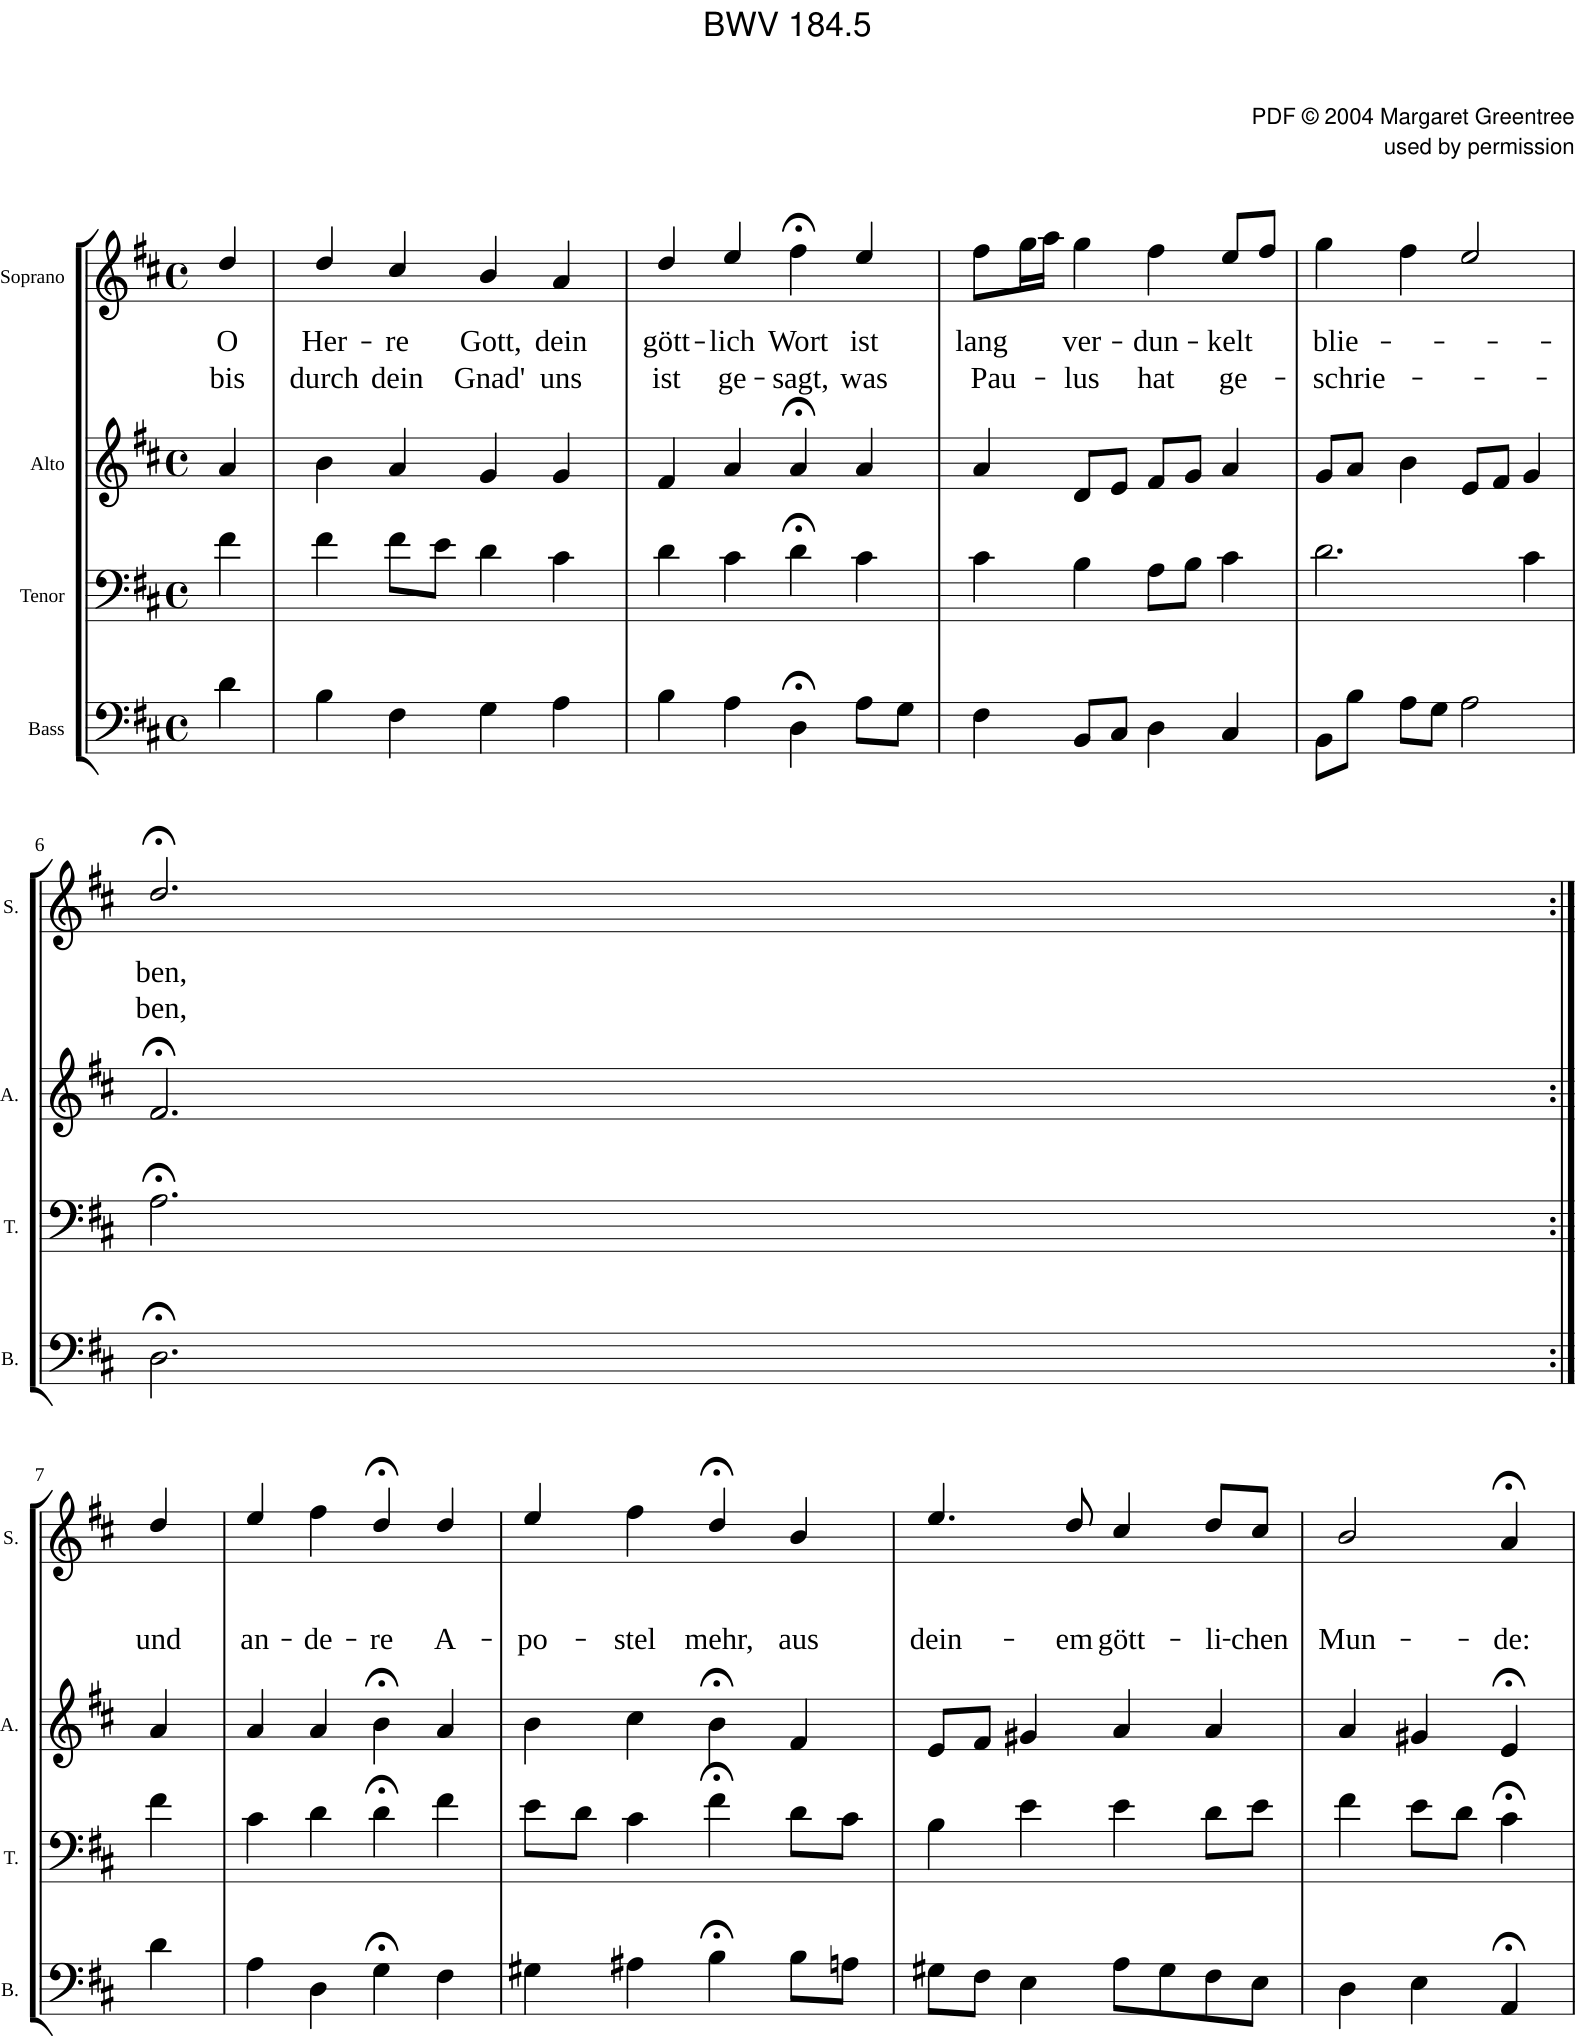

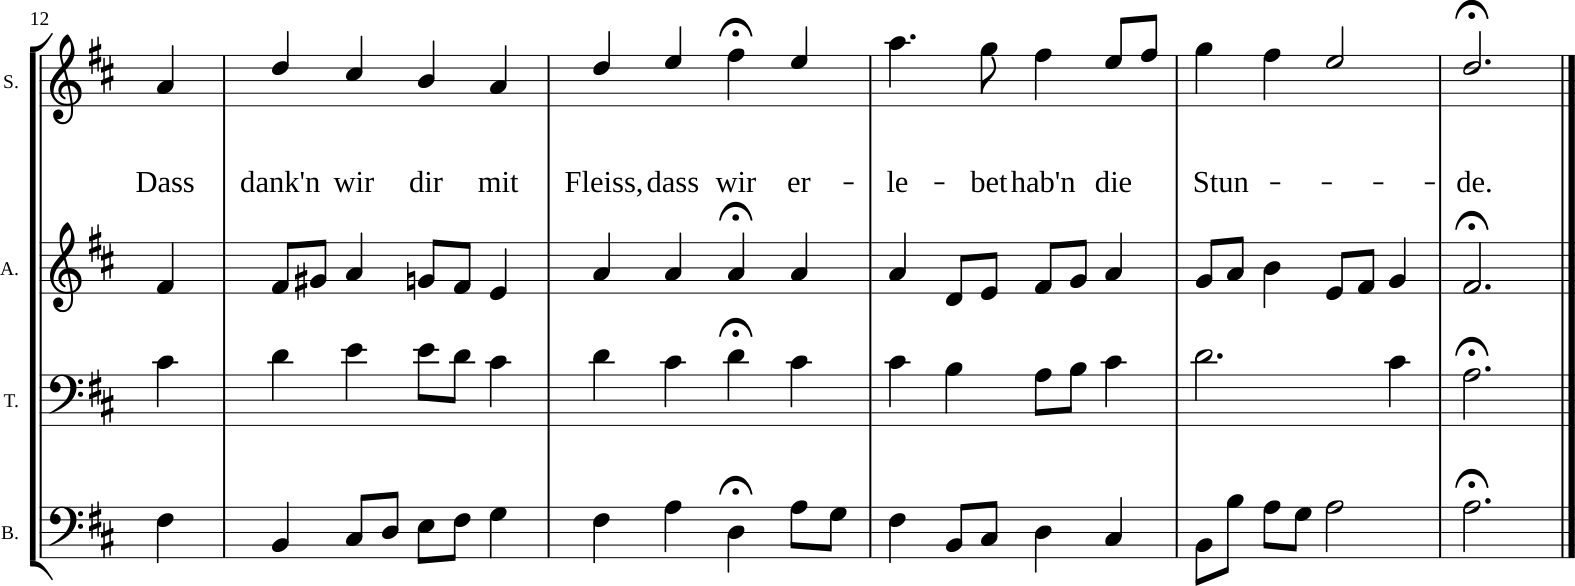

In [ ]:
choral = m21.corpus.chorales.Iterator(returnType='stream')[13]
print(choral.analyze('key'))
choral.show() #chordify().show() # .measures(0,2)

bwv184.5.mxl
5248


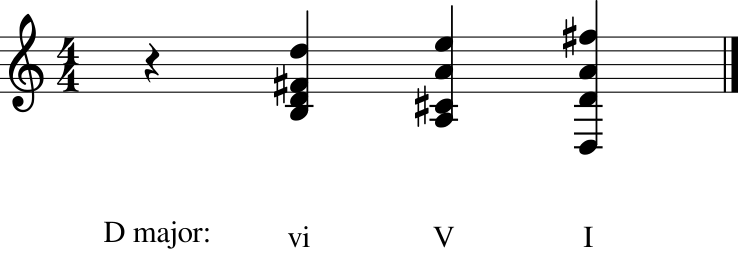


kNN


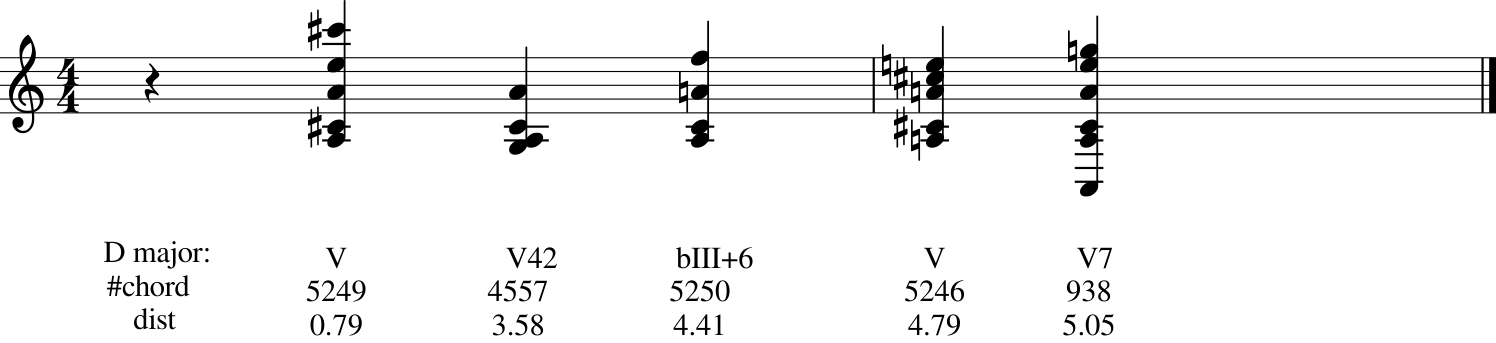

kNN-A


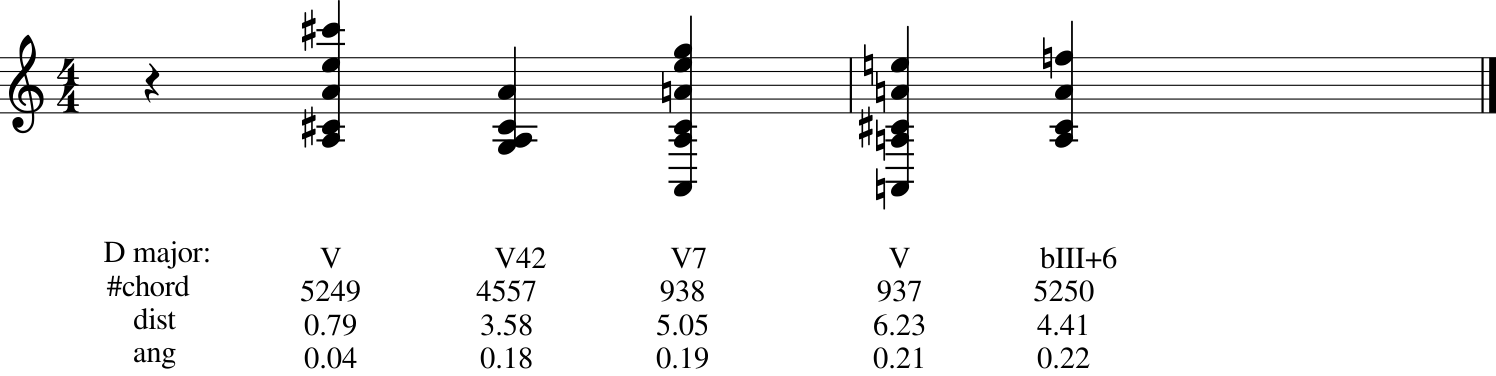

LIN INT


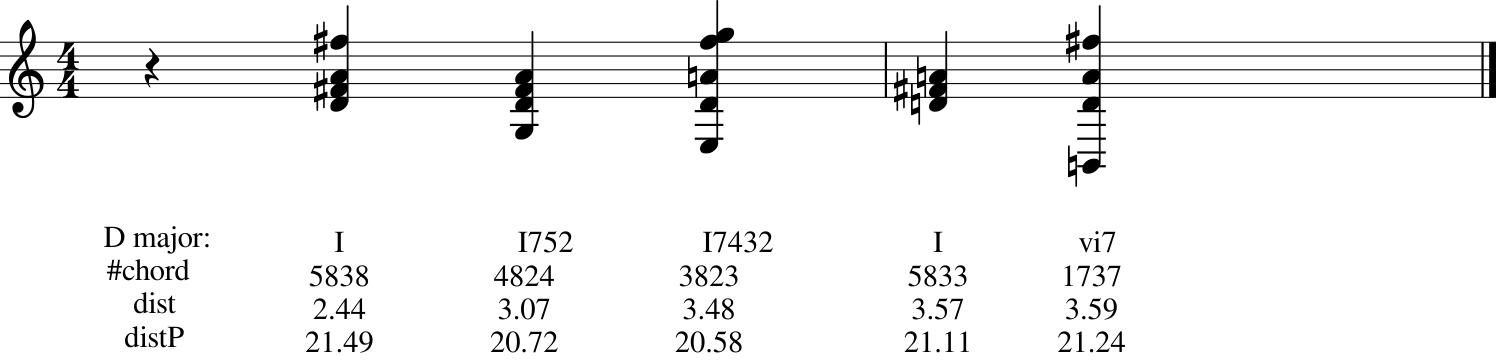

In [ ]:
choral = m21.corpus.chorales.Iterator(returnType='stream')[13] #11-27
chorale_c = choral.chordify(addTies=False)
pitches = ['-'.join([str(int(cp.ps)) for cp in chord.pitches]) for chord in list(chorale_c.recurse(classFilter='Chord'))]
choral_indexes = [[c[0] for c in chords].index(vc) for vc in pitches]
choral_lt = {i:chords_in_lt[i] for i in choral_indexes}

print(choral.metadata.filePath.split('/')[-1])

point = 7
print(choral_indexes[point])

show_original([choral_indexes[point-1], choral_indexes[point], choral_indexes[point+1]], chords, choral.analyze('key'))
print()

print('kNN')
show_results(get_closest_kneigh(choral_indexes[point], choral_indexes, chords_in_lt, numb_closest=5, distanceA='euclidean')[1:],
             chords, 'kNN', choral.analyze('key'))
print('kNN-A')
show_results(get_closest_kneigh_angular(choral_indexes[point], choral_indexes, chords_in_lt, numb_closest=5, distanceA='euclidean', pbef=choral_indexes[point-1])[1:],
             chords, 'kNN-A', choral.analyze('key'))
print('LIN INT')
show_results(get_closest_interpolation(choral_indexes[point], choral_indexes, chords_in_lt, numb_closest=5, distanceA='euclidean', pbes=[choral_indexes[point-1], choral_indexes[point+1]])[:-1],
             chords, 'Inter', choral.analyze('key'))

In [ ]:
#@title Testing Strategies' results with TIV
from scipy import spatial

def calculate_tiv(pitch_classes):
  pcp = np.zeros(12)
  np.add.at(pcp, pitch_classes, 1)

  dft = dft_reduction(pcp, return_complex=True, only_dft=True)
  dft = dft[1:]/dft[0].real

  tiv = dft * [2, 11, 17, 16, 19, 7]
  return [x for y in zip([i.real for i in tiv], [i.imag for i in tiv]) for x in y]

def close_to_tiv(subst_chord, original_chord, chords, distanceA='euclidean'):
  tiv_sub = calculate_tiv([int(x)%12 for x in chords[subst_chord][0].split('-')])
  tiv_org = calculate_tiv([int(x)%12 for x in chords[original_chord][0].split('-')])
  if distanceA == 'euclidean':
    return spatial.distance.euclidean(tiv_sub, tiv_org)
  else:
    return spatial.distance.cosine(tiv_sub, tiv_org) # Fazer também Euclideana

#sug = get_closest_interpolation(point, choral_indexes, chords_in_lt, numb_closest=10, distanceA='euclidean')
#close_to_tiv(sug[0][0], point, chords, "euclidean")

In [ ]:
# @title Iterative Test { vertical-output: true }
distanceL = "cosine" # @param ["cosine", "euclidean"]

import pandas as pd
import tqdm


results = pd.DataFrame(columns=pd.MultiIndex.from_tuples([('Choral', '#'), ('Choral', 'point')] +
                       pd.MultiIndex.from_product([['kNN', 'kNN-A', 'Interp'],['euclidean','cosine']]).tolist()))

if os.path.exists(f'output_{distanceL}_{mode.value}.xlsx'):
  results = pd.read_excel(f'output_{distanceL}_{mode.value}.xlsx', header=[0,1], index_col=0)

for choral in tqdm.tqdm(m21.corpus.chorales.Iterator(returnType='stream')):
  if mode.value != 'all' and choral.analyze('key').mode != mode.value:
    continue

  if choral.metadata.filePath.split('/')[-1] in results[('Choral', '#')].values:
    continue

  chorale_c = choral.chordify(addTies=False)
  pitches = ['-'.join([str(int(cp.ps)) for cp in chord.pitches]) for chord in list(chorale_c.recurse(classFilter='Chord'))]
  choral_indexes = [[c[0] for c in chords].index(vc) for vc in pitches]

  for i, ch in enumerate(choral_indexes[1:-1]):
    vals = {}
    for dist in ['euclidean', 'cosine']:
        sub_1 =  get_closest_kneigh(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist)[1]
        vals[f'{dist}:kNN'] = (sub_1, close_to_tiv(sub_1[0], ch, chords, distanceL))
        sub_2 = get_closest_kneigh_angular(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbef=choral_indexes[i])[1]
        vals[f'{dist}:kNN-A'] = (sub_2, close_to_tiv(sub_2[0], ch, chords, distanceL))
        sub_3 = get_closest_interpolation(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbes=[choral_indexes[i], choral_indexes[i+2]])[0]
        vals[f'{dist}:Interp'] = (sub_3, close_to_tiv(sub_3[0], ch, chords, distanceL))

    results.loc[len(results.index)] = [choral.metadata.filePath.split('/')[-1], ch,
                                    vals['euclidean:kNN'], vals['cosine:kNN'],
                                    vals['euclidean:kNN-A'], vals['cosine:kNN-A'],
                                    vals['euclidean:Interp'], vals['cosine:Interp']]
  results.to_excel(f'output_{distanceL}_{mode.value}.xlsx')

100%|██████████| 371/371 [2:41:50<00:00, 26.17s/it]


In [ ]:
# @title Iterative Test 2 #{ vertical-output: true }

import pandas as pd
import tqdm


results = pd.DataFrame(columns=pd.MultiIndex.from_tuples([('Choral', '#'), ('Choral', 'point')] +
                       pd.MultiIndex.from_product([['Interp-Lin-Euc', 'Interp-Lin-Cos', 'Interp-Log-Euc', 'Interp-Log-Cos'],['euclidean','cosine']]).tolist()))

if os.path.exists(f'output_2_{mode.value}.xlsx'):
  results = pd.read_excel(f'output_2_{mode.value}.xlsx', header=[0,1], index_col=0)

for choral in tqdm.tqdm(m21.corpus.chorales.Iterator(returnType='stream')):
  if mode.value != 'all' and choral.analyze('key').mode != mode.value:
    continue

  if choral.metadata.filePath.split('/')[-1] in results[('Choral', '#')].values:
    continue

  chorale_c = choral.chordify(addTies=False)
  pitches = ['-'.join([str(int(cp.ps)) for cp in chord.pitches]) for chord in list(chorale_c.recurse(classFilter='Chord'))]
  choral_indexes = [[c[0] for c in chords].index(vc) for vc in pitches]

  for i, ch in enumerate(choral_indexes[1:-1]):
    vals = {}
    for dist in ['euclidean', 'cosine']:
        sub_1 = get_closest_interpolation(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbes=[choral_indexes[i], choral_indexes[i+2]])[0]
        vals[f'{dist}:Interp-Euc'] = (sub_1, close_to_tiv(sub_1[0], ch, chords, 'euclidean'))

        sub_2 = get_closest_interpolation(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbes=[choral_indexes[i], choral_indexes[i+2]])[0]
        vals[f'{dist}:Interp-Cos'] = (sub_2, close_to_tiv(sub_2[0], ch, chords, 'cosine'))

        sub_3 = get_closest_interpolation(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbes=[choral_indexes[i], choral_indexes[i+2]], interp='log')[0]
        vals[f'{dist}:Interp-Log-Euc'] = (sub_3, close_to_tiv(sub_3[0], ch, chords, 'euclidean'))

        sub_4 = get_closest_interpolation(ch, choral_indexes, chords_in_lt, numb_closest=10, distanceA=dist, pbes=[choral_indexes[i], choral_indexes[i+2]], interp='log')[0]
        vals[f'{dist}:Interp-Log-Cos'] = (sub_4, close_to_tiv(sub_4[0], ch, chords, 'cosine'))


    results.loc[len(results.index)] = [choral.metadata.filePath.split('/')[-1], ch,
                                    vals['euclidean:Interp-Euc'], vals['cosine:Interp-Euc'],
                                    vals['euclidean:Interp-Cos'], vals['cosine:Interp-Cos'],
                                    vals['euclidean:Interp-Log-Euc'], vals['cosine:Interp-Log-Euc'],
                                    vals['euclidean:Interp-Log-Cos'], vals['cosine:Interp-Log-Cos'],
                                       ]
  results.to_excel(f'output_2_{mode.value}.xlsx')

100%|██████████| 371/371 [5:22:16<00:00, 52.12s/it]
